In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from os.path import join
from tqdm import tqdm
import random
from matplotlib import pyplot as plt
import math
                                                                
project_root = Path('..')

preprocess_path = join(project_root, Path('data/preprocess'))
random.seed(44)

Thoughts: thresholds need to be custom to each profile. This would be a good opportunity to try to make a profile that gets more confident the more data about the author it has. The profile could model distributions of the differences between its sentences to its mean and other people's sentences to its mean. Then it can use these two distributions to determine which is more likely for incoming sentences. 

Question: Can euclidean distances from the mean or cosine similarites be treated as normal random variables?

In [2]:
# Using function words for these experiments
function_words_train = pd.read_hdf(join(preprocess_path, "bawe_train_preprocessed_function_word_counter.hdf5"))
pos_bigrams_train = pd.read_hdf(join(preprocess_path, "bawe_train_preprocessed_pos2gram_counter.hdf5"))

npy_data = np.concatenate([function_words_train.to_numpy(), pos_bigrams_train.to_numpy()], axis=1)

# function_words_train = pd.concat([pos_bigrams_train, function_words_train], axis=1)
function_words_train = pd.DataFrame(data=npy_data, index=pos_bigrams_train.index)

function_words_train

0    1    2    3    4    5    6    7    8    \
author text_id sentence_position                                                
1      0       0                  1.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0   
               1                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0   
               2                  2.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
               3                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0   
               4                  1.0  0.0  0.0  1.0  0.0  0.0  1.0  2.0  0.0   
...                               ...  ...  ...  ...  ...  ...  ...  ...  ...   
6998   2       175                1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
               176                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
               177                1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
               178                0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
               179                3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                  9    ...  423  424  425  426  427  428  429  \
author text_id sentence_position       ...                                      
1      0       0                  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
               1                  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
               2                  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
               3                  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
               4                  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                               ...  ...  ...  ...  ...  ...  ...  ...  ...   
6998   2       175                0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
               176                0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
               177                0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
               178                0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
               179                0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                  430  431  432  
author text_id sentence_position                 
1      0       0                  0.0  0.0  0.0  
               1                  0.0  0.0  0.0  
               2                  0.0  0.0  0.0  
               3                  0.0  0.0  0.0  
               4                  0.0  0.0  0.0  
...                               ...  ...  ...  
6998   2       175                0.0  0.0  0.0  
               176                0.0  0.0  0.0  
               177                0.0  0.0  0.0  
               178                0.0  0.0  0.0  
               179                0.0  0.0  0.0  

[237872 rows x 433 columns]

In [3]:
def select_good_features(df):
    overall_var = df.var()

    author_vars = df.groupby(level="author").var()

    mean_explained_var = (overall_var - author_vars).mean()

    # Features that reduce the variance within classes should hopefully be good
    # features.
    selections = mean_explained_var > 0

    # The index of selctions should be the columns of the dataframe given the
    # last few operations.
    chosen_columns = list(set(selections[selections].index.tolist()))

    return df[chosen_columns], chosen_columns

In [4]:
filtered_train, chosen_columns_ = select_good_features(function_words_train)

pickle.dump(chosen_columns_, open("../outputs/chosen_features.p", "wb"))

filtered_train
# filtered_train = function_words_train

len(chosen_columns_), filtered_train.shape

(153, (237872, 153))

In [5]:
std_train = (filtered_train - filtered_train.mean()) / filtered_train.std()

pca_vals, pca_vecs = np.linalg.eig(std_train.cov())
sorted_indices = np.flip(np.argsort(pca_vals))

pca_vecs = pca_vecs.real

components = pca_vecs[:, sorted_indices][:, :50]

std_train.dot(components)

# isinstance(components, np.ndarray)

np.save("../outputs/pca_components.npy", pca_vecs[:, sorted_indices])

pca_vecs.shape

(153, 153)

In [6]:
pd.concat([std_train.loc[0:1], std_train.loc[1:2]])
pca_train = std_train.dot(components)
lda_train = pca_train.loc[:50]

In [7]:
lda_train.columns = np.arange(len(lda_train.columns))

In [8]:
within_class = lda_train.groupby(level="author").cov().groupby(level=1).mean()

# print(lda_train)
mean_diffs = lda_train.groupby(level="author").mean() - lda_train.mean()
between_class = mean_diffs.cov()

eig_matrix = np.dot(np.linalg.inv(within_class), between_class)

lda_vals, lda_vecs = np.linalg.eig(eig_matrix)
sorted_indices = np.flip(np.argsort(lda_vals))

lda_components = lda_vecs[:, sorted_indices][:, :15].real

np.save("../outputs/lda_components.npy", lda_vecs[:, sorted_indices].real)

In [9]:
transformed = pca_train.dot(lda_components)
filtered_train = transformed
# transformed.index.get_level_values("author")

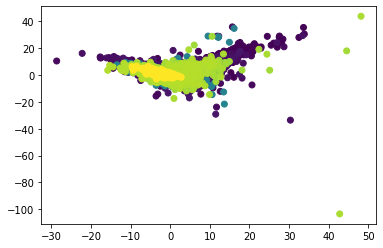

In [10]:
# transformed.groupby(level="author").plot()
# plt.plot(transformed.to_numpy().T)

# plt.show()
# plt_matrix = transformed.to_numpy().T

# x_values = plt_matrix[0]
# y_values = plt_matrix[1]

plt.scatter(transformed[0], transformed[1], c=transformed.index.get_level_values("author"))
# plt.scatter(transformed[0], transformed[1], c=)
plt.show()
# x_values

In [11]:
authors = filtered_train.index.get_level_values("author")
author_set = list(set(authors))

experiment_authors = random.sample(author_set, 10)

experiment_authors

[3052, 6044, 6082, 140, 227, 3019, 281, 370, 30, 6120]

In [12]:
chosen_author = experiment_authors[9]

chosen_author_sentences = filtered_train.loc[chosen_author]

chosen_author_sentences

0         1         2         3         4   \
text_id sentence_position                                                     
0       0                  0.004550 -1.058706 -0.724397 -1.425279  0.066925   
        1                  0.314010 -1.205430  0.055053 -0.254963  1.362805   
        2                  0.541070 -0.016774  0.849161 -0.220401  2.439324   
        3                  0.755791  0.450489  1.879599  0.274744  0.083639   
        4                 -0.439326 -0.119012  0.100043 -0.526236  0.930815   
...                             ...       ...       ...       ...       ...   
3       108               -0.626621 -2.088417 -1.217357 -0.274921  0.359613   
        109                0.283461 -1.063731 -0.934965 -0.508425  0.239503   
        110               -0.491757 -1.981348 -0.259161 -1.588214 -0.479822   
        111                0.723273 -1.453695  0.026126  0.270293  0.095716   
        112                0.417490 -0.459523 -0.249074  1.472813 -1.043069   

                                 5         6         7         8         9   \
text_id sentence_position                                                     
0       0                  1.962802  0.466646 -0.549874 -0.847161 -1.293254   
        1                  0.194961 -0.532178  0.336749  0.104952  0.348546   
        2                 -1.419319  0.639772  3.071276  0.801376  0.594277   
        3                  0.255511 -0.554997  1.242884 -0.997527  1.728886   
        4                  0.297401  0.304557  0.912151  0.305916 -0.964256   
...                             ...       ...       ...       ...       ...   
3       108               -0.651783  1.491583 -0.536878 -0.730725  2.613227   
        109                0.004484  0.261067 -0.915161 -0.615734  0.618153   
        110                0.972102  0.751182  0.189170 -1.084385 -0.256044   
        111                1.331695 -0.709017 -0.799891 -1.519282  0.623122   
        112                0.220920  0.855553  0.447553 -0.965951  0.332732   

                                 10        11        12        13        14  
text_id sentence_position                                                    
0       0                 -0.329116  1.143677 -0.315995  0.262056  0.595627  
        1                 -0.264515  0.375047 -0.157271 -0.294987 -1.183920  
        2                 -1.148924  0.899463 -0.427537  0.529731 -0.930324  
        3                 -1.789830  1.239751 -0.230902  0.403204  0.650573  
        4                 -0.456180  1.242231 -0.587076  0.417523 -0.078134  
...                             ...       ...       ...       ...       ...  
3       108               -0.468206 -1.448219  0.002099  1.904756 -1.752467  
        109                0.219109 -0.688579  0.241970  0.893073  0.061977  
        110               -0.119265  1.351277 -0.244349  0.764023 -1.182235  
        111                1.488655 -1.910261 -0.223778  0.241068 -0.135775  
        112               -0.446512  0.515677 -1.037841  1.216247  0.012302  

[402 rows x 15 columns]

Question: If I take the mean of each sentence distance and include it in the mean instead of excluding it, does this affect the mean/var distance?

In [13]:
included_sentences_distances = np.linalg.norm(chosen_author_sentences - chosen_author_sentences.mean(), axis=1)

included_sentences_distances_mean = included_sentences_distances.mean()
included_sentences_distances_var = included_sentences_distances.var()


def get_excluded_sentence_distances(array):
    def sentence_distance(i):
        selection = [True] * len(array)
        selection[i] = False
        return np.linalg.norm(array[i] - np.mean(array[selection]))

    return np.array([sentence_distance(index) for index in range(len(array))])


excluded_sentence_distances = get_excluded_sentence_distances(chosen_author_sentences.to_numpy())

excluded_sentence_distances_mean = excluded_sentence_distances.mean()
excluded_sentence_distances_var = excluded_sentence_distances.var()

included_sentences_distances_mean, excluded_sentence_distances_mean

(4.096101554555486, 4.198969086686162)

Answer: Yes :(, the mean is consistently much lower because the sentence is included. This is unfortunate because the other method was much more efficient to compute.

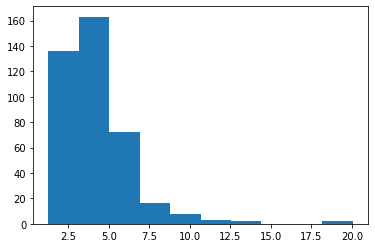

In [14]:
plt.hist(excluded_sentence_distances)

plt.show()

Answer to previous question: Euclidean distances are not normal (no doy why would they be? euclidean distances from same distribution mean should on average be close to 0 and can't be lower than that).

Question: What if I just pick a threshold that accounts for 95% of the author's sentences.

In [15]:
chosen_text = chosen_author_sentences.loc[0]

chosen_sentence_distances = get_excluded_sentence_distances(chosen_text.to_numpy())

index_threshold = math.floor(len(chosen_sentence_distances) * 0.75)
threshold = np.sort(chosen_sentence_distances)[index_threshold]

threshold, index_threshold

(5.078313204042456, 91)

In [16]:
def euclidean_distance(mean, df):
    return np.linalg.norm(mean - df, axis=1)


chosen_text_mean = chosen_text.mean()

same_texts = chosen_author_sentences.drop(index=(0,))
other_author_texts = filtered_train.drop(index=(chosen_author,))

same_sentence_classifications = pd.DataFrame(
    euclidean_distance(chosen_text_mean, same_texts) > threshold, index=same_texts.index
)
other_sentence_classifications = pd.DataFrame(
    euclidean_distance(chosen_text_mean, other_author_texts) > threshold, index=other_author_texts.index
)

same_text_classifications = same_sentence_classifications.groupby(level=("text_id")).mean() > 0.5
other_text_classifications = other_sentence_classifications.groupby(level=("author", "text_id")).mean() > 0.5

same_flags = same_text_classifications.sum()
same_length = len(same_text_classifications)
other_flags = other_text_classifications.sum()
other_length = len(other_text_classifications)

tnr = (same_length - same_flags) / same_length
tpr = other_flags / other_length

tnr[0], tpr[0]

(1.0, 0.056365403304178816)